In [ ]:
from PIL import Image
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor

# Load the model in half-precision on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

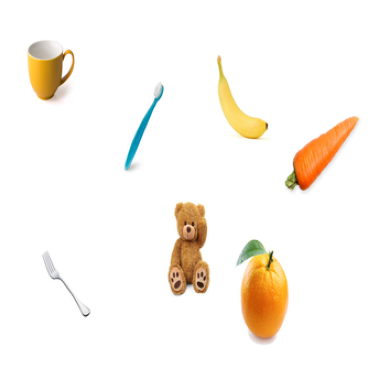

In [2]:
image = Image.open("images/image2.png")

# resize the image to 336x336

image = image.resize((336, 336), Image.LANCZOS) # for speed up

import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(image)
plt.show()


In [3]:
clue = "It is a part of daily hygiene routine."

In [4]:
user_prompt1 = f'''You are an assistant whose task is to identify the correct object from the given image that aligns best with the following clue: '{clue}'
First think about each object's properties in the image, considering how the clue relates to them, directly or indirectly. Then, provide only the name of the correct object as your answer.
No additional explanations.
The answer is: '''

user_prompt2 = f'''From the given image, determine the object that aligns best with the following clue: '{clue}'
First, carefully evaluate the properties of each object in the image, considering how the clue relates to them, directly or indirectly. Then, provide only the name of the correct object as your answer.
No additional explanations.
The answer is: '''


In [6]:
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {"type": "text", "text": user_prompt1},
        ],
    }
]
# Preprocess the inputs
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
# Excepted output: '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'

inputs = processor(
    text=[text_prompt], images=[image], padding=True, return_tensors="pt"
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
output_ids = model.generate(**inputs, max_new_tokens=64, do_sample=False)
generated_ids = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids)
]
answer = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)[0]
print("-"*50)
print("User Prompt: ")
print(user_prompt1)
print("-"*50)
print("Model Response: ")
print(answer)

--------------------------------------------------
User Prompt: 
You are an assistant whose task is to identify the correct object from the given image that aligns best with the following clue: 'It is a part of daily hygiene routine.'
First think about each object's properties in the image, considering how the clue relates to them, directly or indirectly. Then, provide only the name of the correct object as your answer.
No additional explanations.
The answer is: 
--------------------------------------------------
Model Response: 
Toothbrush


In [7]:
answer

'Toothbrush'

In [12]:
# preprocess the answer
answer = answer.lower().strip()
if "[" == answer[0] or "(" == answer[0]:
    answer = answer[1:]
if "]" == answer[-1] or ")" == answer[-1]:
    answer = answer[:-1]

answer

'toothbrush'

In [13]:
import sys
sys.path.append('./YOLO-World/')

In [14]:
import numpy as np
from mmengine.config import Config
from mmengine.dataset import Compose
from mmengine.runner import Runner
from mmengine.runner.amp import autocast
from mmyolo.registry import RUNNERS
from torchvision.ops import nms

In [ ]:
# load config
cfg = Config.fromfile(
    "YOLO-World/configs/pretrain/yolo_world_v2_l_vlpan_bn_2e-3_100e_4x8gpus_obj365v1_goldg_train_1280ft_lvis_minival.py"
)
cfg.work_dir = "./YOLO-World/"
cfg.load_from = "YOLO-World/pretrained_weights/yolo_world_v2_l_obj365v1_goldg_pretrain_1280ft-9babe3f6.pth"
runner = Runner.from_cfg(cfg)
runner.call_hook("before_run")
runner.load_or_resume()
pipeline = cfg.test_dataloader.dataset.pipeline
runner.pipeline = Compose(pipeline)

# run model evaluation
runner.model.eval()

In [22]:
def colorstr(*input):
    """
        Helper function for style logging
    """
    *args, string = input if len(input) > 1 else ("bold", input[0])
    colors = {"bold": "\033[1m"}

    return "".join(colors[x] for x in args) + f"{string}"

In [25]:
class_name = (answer)

In [ ]:
from unittest import skip
import PIL.Image
import cv2
import supervision as sv

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)
mask_annotator = sv.MaskAnnotator()

def run_image(
        runner,
        input_image,
        max_num_boxes=1,
        score_thr=0.05,
        nms_thr=0.5,
        output_image="output.png",
):
    output_image = "images/output/"+output_image
    texts = [[t.strip()] for t in class_name.split(",")] + [[" "]]
    data_info = runner.pipeline(dict(img_id=0, img_path=input_image,
                                     texts=texts))

    data_batch = dict(
        inputs=data_info["inputs"].unsqueeze(0),
        data_samples=[data_info["data_samples"]],
    )

    with autocast(enabled=False), torch.no_grad():
        output = runner.model.test_step(data_batch)[0]
        runner.model.class_names = texts
        pred_instances = output.pred_instances

    # nms
    keep_idxs = nms(pred_instances.bboxes, pred_instances.scores, iou_threshold=nms_thr)
    pred_instances = pred_instances[keep_idxs]
    pred_instances = pred_instances[pred_instances.scores.float() > score_thr]

    if len(pred_instances.scores) > max_num_boxes:
        indices = pred_instances.scores.float().topk(max_num_boxes)[1]
        pred_instances = pred_instances[indices]
    output.pred_instances = pred_instances

    # predictions
    pred_instances = pred_instances.cpu().numpy()

    if 'masks' in pred_instances:
        masks = pred_instances['masks']
    else:
        masks = None
        
    detections = sv.Detections(
        xyxy=pred_instances['bboxes'],
        class_id=pred_instances['labels'],
        confidence=pred_instances['scores']
    )

    # label ids with confidence scores
    labels = [
        f"{class_name[0]} {confidence:0.2f}"
        for class_name, confidence
        in zip(texts, detections.confidence)
    ]

    # draw bounding box with label
    image = PIL.Image.open(input_image)
    svimage = np.array(image)
    svimage = bounding_box_annotator.annotate(svimage, detections, skip_label=True)
    svimage = label_annotator.annotate(svimage, detections, labels)
    if masks is not None:
        svimage = mask_annotator.annotate(image, detections)

    # save output image
    cv2.imwrite(output_image, svimage[:, :, ::-1])
    print(f"Results saved to {colorstr('bold', output_image)}")

    return svimage[:, :, ::-1]


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


Results saved to images/output/vlm_and_yollo_world_output.png


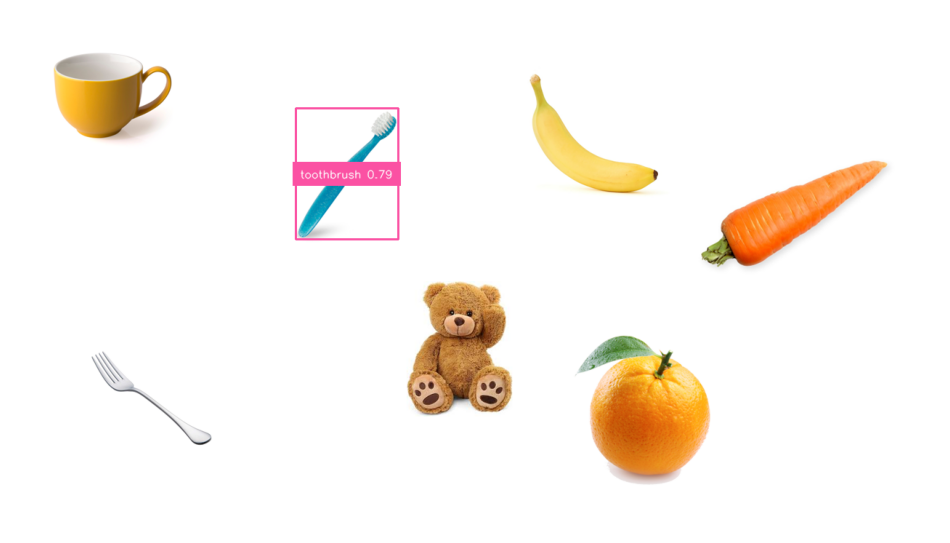

In [24]:
img = run_image(runner,"images/image2.png", output_image="vlm_and_yollo_world_output.png")
sv.plot_image(img)